In [1]:
from helperFunctions import *
from constants import *
import pandas as pd

In [2]:
'''
Files that work with this notebook: 
Anything in filtered*_data

'''

filename_foldername_dict_path = "../data/most_currently_updated.pickle"
filename_foldername_dict = loadPickle(filename_foldername_dict_path)

foldername=filename_foldername_dict["foldername"]
filename=filename_foldername_dict["filename"]
print(foldername, filename)

filtered_data_directory = "../data/filtered_data/"+foldername+"/"
filtered_cleaned_data_directory = "../data/filtered_cleaned_data/"+foldername+"/"

filtered_data_path = filtered_data_directory+filename+".pickle"
filtered_cleaned_data_path = filtered_cleaned_data_directory+filename+".pickle"

filtered_cleaned_data = loadPickle(filtered_cleaned_data_path)

P005 participant_P005_exp001_block_long


## Get sections


In [3]:
# Get sections
numSections = getNumSections(filtered_cleaned_data)
article_sections = list()
for i in range(numSections) : 
    article_sections.append(getArticleSectionData("response", i, filtered_cleaned_data))


## Get Meme shown data and times


In [4]:
# Get meme shown data
meme_shown_string = getLabelMarkerString("memeShown")

meme_is_shown_data, a, b = getLabelBoundSingleLabelData("memeShown", "memeHidden", filtered_cleaned_data, go_backward=False)
if len(meme_is_shown_data) == 0: 
    articles_with_memes = list()
    articles_without_memes = list() 
    for section in article_sections:
        if meme_shown_string in section[StreamType.MARKER.value][StreamType.DATA.value] :
            articles_with_memes.append(section)
        else : 
            articles_without_memes.append(section)
    meme_is_shown_data = articles_with_memes
    
# Determine the time frames in which the memes are shown
meme_shown_times = list() 
for data in meme_is_shown_data:
    start_time = data[StreamType.MARKER.value][StreamType.TIME.value][0]
    end_time = data[StreamType.MARKER.value][StreamType.TIME.value][-1]
    meme_shown_times.append((start_time, end_time))


## Get Eye Looking data

/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/filter.py:86: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/iir.py:136: UserWarning: IIR filters are not recommended other than for notch filters.
  warn('IIR filters are not recommended other than for notch filters.')
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/checks.py:144: UserWarning: Transition bandwidth is  4.0  Hz. This is greater than the desiredpass/stop bandwidth of  2.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an 

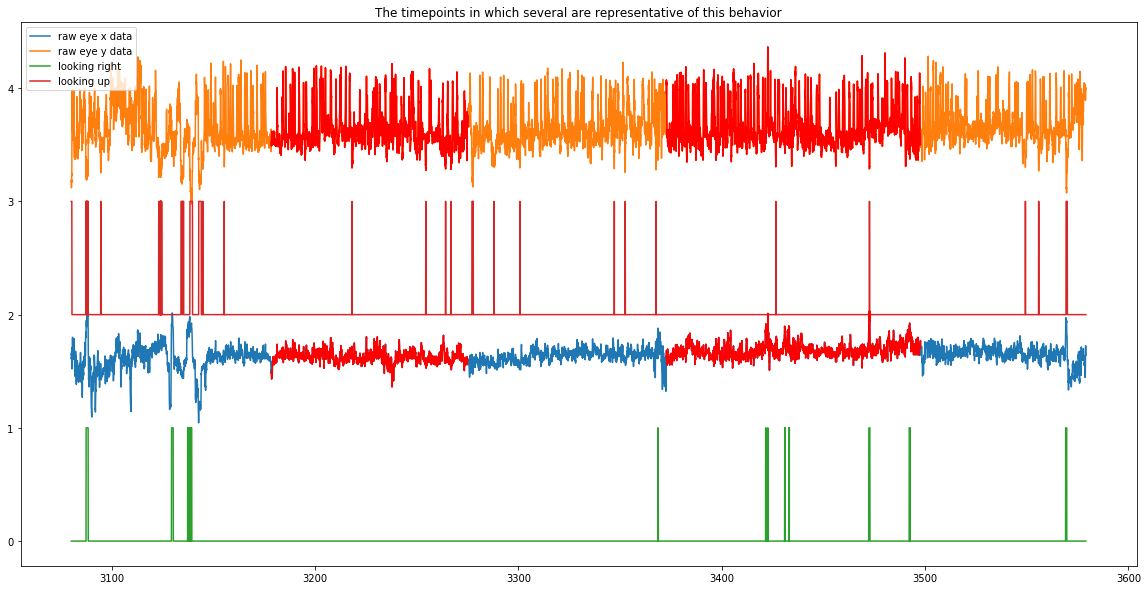

In [5]:
## TWEAK these numbers to see what valeus would work best when inputted into the function
percent_distance_from_center = 9/10
percent_distance_from_center_y = 7/10

eye_x_data=filtered_cleaned_data[StreamType.EYENORM.value][StreamType.DATA.value][:,0]
eye_y_data=filtered_cleaned_data[StreamType.EYENORM.value][StreamType.DATA.value][:,1]
eye_time_data=filtered_cleaned_data[StreamType.EYENORM.value][StreamType.TIME.value]
plt.figure(figsize=(20,10))

plt.plot(eye_time_data[:], eye_x_data[:] + 1, label="raw eye x data")
plt.plot(eye_time_data[:], eye_y_data[:] + 3, label="raw eye y data")

# Plot eye movement predictions
avg_calibrated_x, avg_calibrated_y = getAvgCalibratedXandY(filtered_cleaned_data)
looking_right = getLookingRightTimes(filtered_cleaned_data, avg_calibrated_x, avg_calibrated_y, percent_distance_from_center)
looking_up = getLookingUpTimes(filtered_cleaned_data, avg_calibrated_x, avg_calibrated_y, percent_distance_from_center_y)

plt.plot(eye_time_data[:], looking_right, label="looking right")
plt.plot(eye_time_data[:], np.array(looking_up)+2, label="looking up")
plt.legend()
plt.title("The timepoints in which several are representative of this behavior")


# Plot meme shown sections
meme_shown_data, a, b = getLabelBoundSingleLabelData("memeShown", "memeHidden", filtered_cleaned_data, go_backward=False)
for i in range(len(meme_shown_data)): 
    eye_x_data=meme_shown_data[i][StreamType.EYENORM.value][StreamType.DATA.value][:,0]
    eye_y_data=meme_shown_data[i][StreamType.EYENORM.value][StreamType.DATA.value][:,1]
    eye_time_data=meme_shown_data[i][StreamType.EYENORM.value][StreamType.TIME.value]

    if i == 0:
        plt.plot(eye_time_data, eye_x_data + 1, color="r", label="meme shown time")
    else : 
        plt.plot(eye_time_data, eye_x_data + 1, color="r")
    plt.plot(eye_time_data, eye_y_data + 3, color="r")

plt.show()

In [6]:
eye_time_data=filtered_cleaned_data[StreamType.EYENORM.value][StreamType.TIME.value]


filtered_cleaned_data[StreamType.LOOKING_UP.value] = dict()
filtered_cleaned_data[StreamType.LOOKING_UP.value][StreamType.DATA.value] = np.array(looking_up)
filtered_cleaned_data[StreamType.LOOKING_UP.value][StreamType.TIME.value] = np.array(eye_time_data)

filtered_cleaned_data[StreamType.LOOKING_RIGHT.value] = dict()
filtered_cleaned_data[StreamType.LOOKING_RIGHT.value][StreamType.DATA.value] = np.array(looking_right)
filtered_cleaned_data[StreamType.LOOKING_RIGHT.value][StreamType.TIME.value] = np.array(eye_time_data)



In [7]:
type(filtered_cleaned_data[StreamType.LOOKING_UP.value][StreamType.TIME.value][0])

numpy.float64

## Construct Data Frame

In [8]:
start_marker_string = getLabelMarkerString("newWord")
end_marker_string = getLabelMarkerString("endWord")
target_word_string = getSingleLabelMarkerString("targetWord")
space_pressed_string = getSingleLabelMarkerString("spacePressed")
response_start_string = getSectionMarkerString("response")[0] # Get the 0th element to get the start string
space_pressed_string = getLabelMarkerString("spacePressed")
letters_shown_string = getLabelMarkerString("lettersShown")

In [9]:
# Construct data frame 

# This version doesn't work because we need to know when the neew article starts. 
# new_word_data, a, t_data = getLabelBoundSingleLabelData("newWord", "endWord", filtered_cleaned_data, go_backward=False)
# points = [getTotalPoints(data) for data in new_word_data] 


new_word_data, a, t_data = getTimeBoundSingleLabelData("newWord", filtered_cleaned_data, time_before=0.5, time_after=1.5)
points = [getTotalPoints(data) for data in new_word_data] 

data_info = dict() 
data_info["data_index"] = list() 
data_info["data"] = list() 
data_info["data_extended"] = list()
data_info["is_target"] = list() 
data_info["is_pressed"] = list()
data_info["has_letters_shown"] = list() 
data_info["has_meme"] = list() 
data_info["time"] = list() 
data_info["points"] = list() 
data_info["reaction_time"] = list() 
data_info["section_number"] = list()
data_info["looking_up"] = list()
data_info["looking_right"] = list()


section_number = 0

end_times = list()
for i, point in enumerate(points):
    if(response_start_string in new_word_data[i][StreamType.MARKER.value][StreamType.DATA.value]) : 
        section_number += 1
    
    # Find this word's start and end indexes 
    marker_indexes = getMarkerIndexes(new_word_data[i])
    start_word_index = marker_indexes[start_marker_string][0]
    end_word_index = marker_indexes[end_marker_string][-1]
    end_time = float(new_word_data[i][StreamType.MARKER.value][StreamType.TIME.value][end_word_index])
    end_times.append(end_time)
    # Determine if meme was shown
    has_meme = False
    for meme_shown_interval in meme_shown_times: 
        if (end_time > meme_shown_interval[0] and end_time < meme_shown_interval[1]) :
            has_meme = True
            break

    # Determine if word is a target word
    is_target = False
    if target_word_string in new_word_data[i][StreamType.MARKER.value][StreamType.DATA.value][start_word_index:end_word_index] : 
        is_target = True
    
    # Determine if word was pressed on 
    is_pressed = False
    if space_pressed_string in new_word_data[i][StreamType.MARKER.value][StreamType.DATA.value][start_word_index:end_word_index] : 
        is_pressed = True
        
    # Determine if word had letters shown
    has_letters_shown = False
    if letters_shown_string in new_word_data[i][StreamType.MARKER.value][StreamType.DATA.value][start_word_index:end_word_index] : 
        has_letters_shown = True
            
    
    # Get reaction time
    data_list = getTrials(new_word_data[i])
    this_data = data_list[0]
    reaction_time = getReactionTime(this_data)
    
    new_data, _, _ = getLabelBoundSingleLabelData("newWord", "endWord", new_word_data[i], go_backward=False)
    new_data = new_data[0]
    if i == 190: 
        print(new_word_data[i][StreamType.MARKER.value][StreamType.TIME.value])
    
    data_info["data_index"].append(i)
    data_info["data"].append(new_data)
    data_info["data_extended"].append(new_word_data[i])
    data_info["is_target"].append(is_target)
    data_info["is_pressed"].append(is_pressed)
    data_info["has_letters_shown"].append(has_letters_shown)
    data_info["has_meme"].append(has_meme)
    data_info["time"].append(t_data[i])
    data_info["points"].append(point)
    data_info["section_number"].append(section_number)
    data_info["reaction_time"].append(reaction_time)
    data_info["looking_up"].append(np.sum(new_word_data[i][StreamType.LOOKING_UP.value][StreamType.DATA.value]))
    data_info["looking_right"].append(np.sum(new_word_data[i][StreamType.LOOKING_RIGHT.value][StreamType.DATA.value]))

df = pd.DataFrame.from_dict(data_info)

[3376.05629905 3376.25613675 3376.25617546 3376.2561842  3376.25619026
 3376.26007071 3376.26008066 3376.26008657 3376.26009296 3376.26010806
 3377.07311916 3377.27102678 3377.27105962 3377.27106694 3377.27107172
 3377.27400971 3377.27401815 3377.27402299 3377.27402779 3377.2740402 ]


In [10]:
df.iloc[190]

data_index                                                         190
data                 {'aux': {'time': [3376.261311715082, 3376.2616...
data_extended        {'aux': {'time': [3375.7658348363793, 3375.766...
is_target                                                        False
is_pressed                                                       False
has_letters_shown                                                False
has_meme                                                          True
time                                                           3376.26
points                                                               0
reaction_time                                                        0
section_number                                                       4
looking_up                                                           0
looking_right                                                        0
Name: 190, dtype: object

## Visualize data

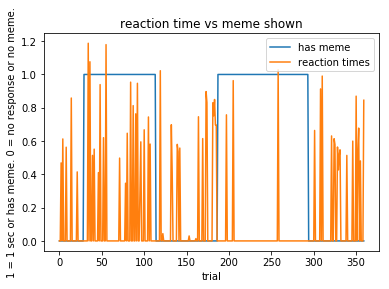

This shows if there's any correlation between showing the memes and a elongation of reaction time


In [11]:
# Display reaction times
plt.plot(df["has_meme"], label="has meme")
plt.plot(df["reaction_time"], label="reaction times")

plt.xlabel("trial")
plt.ylabel("1 = 1 sec or has meme. 0 = no response or no meme.")
plt.title("reaction time vs meme shown")
plt.legend()
plt.show()

print("This shows if there's any correlation between showing the memes and a elongation of reaction time")

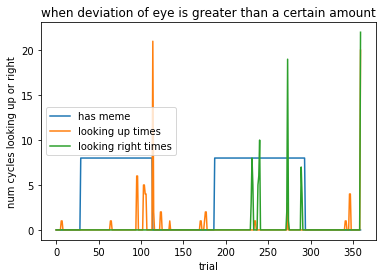

This shows when the subject may be looking right or up


In [12]:
# Display eye looking times
plt.plot(df["has_meme"] * 8, label="has meme")

plt.plot(df["looking_up"], label="looking up times")
plt.plot(df["looking_right"], label="looking right times")


plt.xlabel("trial")
plt.ylabel("num cycles looking up or right")
plt.title("when deviation of eye is greater than a certain amount")
plt.legend()
plt.show()

print("This shows when the subject may be looking right or up")


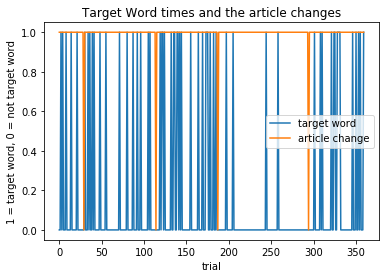

This shows the distribution of target words shown


In [13]:
# Article section dividers with target word times
plt.plot(df["is_target"], label="target word")
plt.plot([ 0 if (i > 0) and (df["section_number"][i-1] != df["section_number"][i]) else 1 for i, row in df.iterrows()], label="article change")
plt.title("Target Word times and the article changes")
plt.xlabel("trial")
plt.ylabel("1 = target word, 0 = not target word")
plt.legend()
plt.show()

print("This shows the distribution of target words shown")

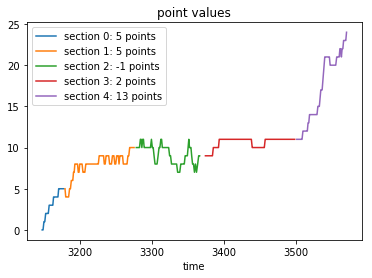

In [14]:
# Plot points
for i, article_section in enumerate(article_sections):
    data, time = getPointsAfterEachWord(article_section)
    num_delta_points = getTotalPoints(article_section)
    plt.plot(time[:], data[:], label="section " + str(i) + ": " + str(num_delta_points) + " points")
plt.title("point values")
plt.xlabel("time")
plt.legend()
plt.show()

## Output dataframe

In [15]:
dataframe_directory = "../data/dataframe/"+foldername+"/"
dataframe_path = dataframe_directory+filename+".pickle"

ensureDirExists(dataframe_directory)

writeToPickle(df, dataframe_path)
print("Done!")
print(foldername, filename)


Done!
P005 participant_P005_exp001_block_long
